In [2]:
# pip install geopandas matplotlib pillow

In [3]:
# import os
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from PIL import Image
# import io
# from tqdm import tqdm

# def process_json_file(json_file, output_folder):
#     # JSON 파일 불러오기
#     gdf = gpd.read_file(json_file)

#     # 이미지 크기 설정
#     image_size = (512, 512)

#     # 폴리곤을 하나의 이미지로 합치기
#     fig, ax = plt.subplots(figsize=(5, 5))
#     fig.patch.set_facecolor('white')  # 배경색을 흰색으로 설정

#     for idx, row in gdf.iterrows():
#         # 각 폴리곤을 'ANN_CD' 값에 따라 다른 그레이스케일 톤으로 채움
#         gray_value = row['ANN_CD'] / 255
#         gdf[gdf.index == idx].plot(ax=ax, color=(gray_value, gray_value, gray_value))

#     # 축 제거 및 이미지 크기 조정
#     plt.axis('off')
#     plt.xlim(gdf.total_bounds[0], gdf.total_bounds[2])
#     plt.ylim(gdf.total_bounds[1], gdf.total_bounds[3])
#     ax.set_aspect('equal', adjustable='box')

#     # 이미지로 변환
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')
#     buf.seek(0)
#     img = Image.open(buf)
#     img = img.resize(image_size, Image.Resampling.LANCZOS)
#     buf.close()
#     plt.close(fig)

#     # 이미지 파일 이름 설정 (JSON 파일 이름 기반)
#     image_file_name = os.path.splitext(os.path.basename(json_file))[0] + '.png'
#     image_path = os.path.join(output_folder, image_file_name)

#     # 이미지 저장
#     img.save(image_path)

In [4]:
import cv2
import numpy as np
import geopandas as gpd
import os
from tqdm import tqdm

def process_json_file(json_file, output_folder, image_size = (512, 512)):
    # JSON 파일 불러오기
    gdf = gpd.read_file(json_file)
    # 이미지 크기 설정
    # 빈 이미지 생성 (모든 픽셀을 흰색으로 설정)
    img = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 255
    
    # 좌표 변환을 위한 최소, 최대 좌표 계산
    x_min, y_min, x_max, y_max = gdf.total_bounds
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    # 'ANN_CD' 필드의 최대값 설정
    max_ann_cd = 255
    class_mapping = {
    210: 160,
    220: 170,
    230: 180
    }
    #ANNCD값으로 GT생성
    for idx, row in gdf.iterrows():
        # 'ANN_CD' 값 변환
        if row['ANN_CD'] in class_mapping:
            ann_cd_transformed = class_mapping[row['ANN_CD']]
        else:
            ann_cd_transformed = row['ANN_CD']
        # 각 폴리곤의 'ANN_CD' 값이 190을 초과하는 경우 190으로 설정
        ann_cd = min(row['ANN_CD'], max_ann_cd)

        color = (ann_cd, ann_cd, ann_cd)  # 그레이스케일
        
        # 폴리곤의 좌표를 이미지의 픽셀 좌표로 변환
        coordinates = row.geometry.exterior.coords.xy
        x_coordinates = (np.array(coordinates[0]) - x_min) / x_range * image_size[0]
        y_coordinates = image_size[1] - (np.array(coordinates[1]) - y_min) / y_range * image_size[1]  # y축 방향 반전
        polygon = np.array([list(zip(x_coordinates, y_coordinates))], dtype=np.int32)
        
        # 폴리곤의 영역을 그레이스케일 톤으로 채우기
        cv2.fillPoly(img, polygon, color)
    
    # 이미지 파일 이름 설정 (JSON 파일 이름 기반)
    image_file_name = os.path.splitext(os.path.basename(json_file))[0] + '.png'
    image_path = os.path.join(output_folder, image_file_name)
    
    # 이미지 저장
    cv2.imwrite(image_path, img)
    
    # # 이미지 화면에 표시
    # cv2.imshow('Image', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
# 폴더 경로 설정
folder_path = ['Dataset\Training\label\AP10_City_Json','Dataset\Training\label\AP10_Forest_Json','Dataset\Training\label\SN10_Forest_Json','Dataset\Training\label\AP25_City_Json','Dataset\Training\label\AP25_Forest_Json',
               'Dataset\Validation\label\AP10_City_Json','Dataset\Validation\label\AP10_Forest_Json','Dataset\Validation\label\AP25_City_Json','Dataset\Validation\label\AP25_Forest_Json','Dataset\Validation\label\SN10_Forest_Json']
for path in folder_path:
    if path == 'Dataset\Training\label\SN10_Forest_Json' or  path == 'Dataset\Validation\label\SN10_Forest_Json' :
        image_size = (256,256)
    else:
        image_size = (512,512)
    print(path)
    output_folder = path.replace('Json', 'GT')
    # output_folder가 존재하지 않으면 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder, exist_ok=True)
    # 폴더 내의 모든 JSON 파일에 대해 작업 수행
    for file in tqdm(os.listdir(path)):
        if file.endswith('.json'):
            json_file_path = os.path.join(path, file)
            process_json_file(json_file_path, output_folder,image_size=image_size)


In [5]:

class Mapping():
    def __init__(self, folder_path):
        if "AP10_City" in folder_path:
            self.label_name = "AP10_City"
            self.label_mapping={0:   0,                      
                                110: 1,
                                120: 2,
                                130: 3,
                                140: 4,
                                210: 5,
                                220: 6,
                                230: 7, 
                                190: 8,
                                255: 0}
        if "AP25_City" in folder_path:
            self.label_name = "AP25_City"
            self.label_mapping={0:   0,                      
                                110: 1,
                                120: 2,
                                130: 3,
                                140: 4,
                                210: 5,
                                220: 6,
                                230: 7, 
                                190: 8,
                                255: 0}
        if "AP10_Forest" in folder_path:
            self.label_name = "AP10_Forest"
            self.label_mapping={0:  0,                      
                                110: 1,
                                120: 2,
                                130: 3,
                                140: 4,
                                150: 5,
                                190: 6, 
                                255: 0}
        if "AP25_Forest" in folder_path:
            self.label_name = "AP25_Forest"
            self.label_mapping={0: 0,                      
                                110:1,
                                120:2,
                                130:3,
                                140: 4,
                                150: 5,
                                190: 6, 
                                255: 0}
        if "SN10_Forest" in folder_path:
            self.label_name = "SN10_Forest"
            self.label_mapping={0:  0,                      
                                140: 1,
                                150: 2,
                                190: 4, 
                                255: 0}
    def __call__(self, img):
        return self.gt_mapping(img)

    def gt_mapping(self, img):
        # PIL 이미지를 NumPy 배열로 변환
        image_np = np.array(img)
        
        # 출력 배열 초기화 (입력 이미지와 동일한 크기)
        mapped_image_np = np.zeros_like(image_np)
        
        # 라벨 매핑 적용
        for original_label, mapped_label in self.label_mapping.items():
            mapped_image_np[image_np == original_label] = mapped_label
        
        # 매핑된 NumPy 배열을 다시 PIL 이미지로 변환 (필요한 경우)
        mapped_image = Image.fromarray(mapped_image_np)
        
        return mapped_image

<PIL.Image.Image image mode=L size=512x512 at 0x2C88A4DB510>


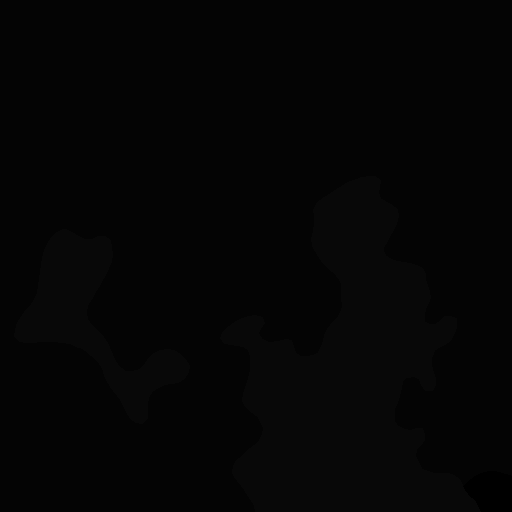

In [19]:
import cv2
import numpy as np
import PIL.Image as Image
#image = cv2.imread("C:\Workspace\CarbonCapturePredict\Dataset\Training\label\AP10_City_GT\AP_10_CT_37705082_4032.png", cv2.IMREAD_GRAYSCALE)
image = Image.open("Dataset\Training\label\AP10_Forest_GT\AP_10_37604057_0126.png").convert('L')
# 픽셀 값 확인
print(image)
mapping = Mapping("C:\Workspace\CarbonCapturePredict\Dataset\Training\label\AP10_City_GT")
mapped_image = mapping(image)
mapped_image

In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from dataset import CarbonDataset
import torch

folder_path = 'Dataset/Training/image/AP10_Forest_IMAGE'
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
transform_label = transforms.Compose([transforms.Resize((256//4, 256//4))])
# Create an instance of the CustomImageDataset class
dataset = CarbonDataset(folder_path,transform,transform,transform_label, mode = "Train")
# 집합(set)을 사용하여 모든 고유값을 저장
unique_values_set = set()
# Create a data loader for the dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
sample_index = 0
# Iterate over the dataset and print the images and labels
for _, _, gt in dataloader:
    for i in range(len(gt)):
        #carbon
        # print(carbon[i].shape, carbon[i].type())
        # print(carbon.min(), carbon.max())
        # print(carbon)
        # plt.imshow(carbon[i].squeeze(), cmap='gray')
        # plt.title("Sample Carbon")
        # plt.show()
        #gt
        print("GT:",gt[i].shape, gt[i].type())
        print(gt.min(), gt.max())
        # gt 텐서의 고유값 찾기
        unique_values = torch.unique(gt)    
        # 집합에 추가하여 중복 제거
        unique_values_set.update(unique_values.cpu().numpy().tolist())
        # print(gt)
        # plt.imshow(gt[i].squeeze(), cmap='gray')  # squeeze()는 1채널 이미지의 경우 채널 차원을 제거
        # plt.title("Sample GT")
        # plt.show()
# 집합을 리스트로 변환하고 정렬
unique_values_list = sorted(list(unique_values_set))
print("GT의 고유값 리스트:", unique_values_list)

Training Set
Dataset/Training/image/AP10_Forest_IMAGE Done./
Dataset/Training/image/AP10_Forest_SH Done./
Dataset/Training/label/AP10_Forest_Carbon Done./
Dataset/Training/label/AP10_Forest_GT Done./
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tensor(6)
GT: torch.Size([64, 64]) torch.LongTensor
tensor(0) tens